In [26]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as mtri

In [32]:
# Code from https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
def simple_cull(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow, row):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    # Accuracy needs to be higher, Privacy budget lower, and the Fairness (risk difference) also lower
    return row[0] >= candidateRow[0] and row[1] <= candidateRow[1] and row[2] <= candidateRow[2] and not(row[0] == candidateRow[0] and row[1] == candidateRow[1] and row[2] == candidateRow[2])

In [41]:
def make_interactive_plot_3D(
    results_path,
    is_grid_or_random,
    add_trianuglar_mesh,
    title
):
    def get_dominated_and_non_dominated_points(df_path, is_grid_or_random):
        results = pd.read_csv(df_path)
        
        if is_grid_or_random:
            inputPoints = [
                [1 - list(results['Classification error'])[i], list(results['Privacy budget'])[i], list(results['Fairness after'])[i]] 
                for i in range(len(results))
                ]
        else:
            inputPoints = [
                [list(results['Accuracy'])[i], list(results['Privacy budget'])[i], list(results['Fairness after'])[i]]
                for i in range(len(results))
                ]

        paretoPoints, dominatedPoints = simple_cull(inputPoints, dominates)

        return paretoPoints, dominatedPoints

    paretoPoints_mobo_ADULT, dominatedPoints_mobo_ADULT = get_dominated_and_non_dominated_points(
        results_path, 
        is_grid_or_random = is_grid_or_random
        )

    fig = plt.figure()
    fig.patch.set_facecolor('white')

    ax = fig.add_subplot(111, projection='3d')
    dominated_points = np.array(list(dominatedPoints_mobo_ADULT))
    pareto_points = np.array(list(paretoPoints_mobo_ADULT))

    ax.scatter(dominated_points[:,0], dominated_points[:,1], dominated_points[:,2])
    ax.scatter(pareto_points[:,0], pareto_points[:,1], pareto_points[:,2],color='red')

    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Privacy budget')
    ax.set_zlabel('Statistical Parity Difference')
    ax.set_title(title)

    plt.gca().patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
    ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
    ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
    
    if add_trianuglar_mesh:
        triang_mobo_ADULT = mtri.Triangulation(pareto_points[:,0], pareto_points[:,1])
        ax.plot_trisurf(triang_mobo_ADULT, pareto_points[:,2], color = 'red')

    ax.view_init(30, 60)

<IPython.core.display.Javascript object>


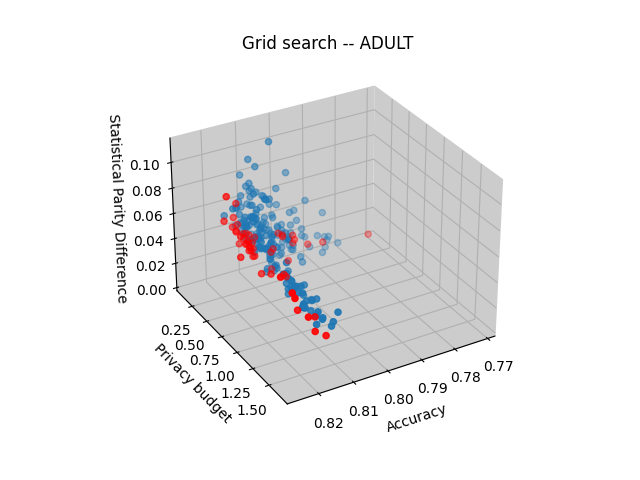

In [48]:
make_interactive_plot_3D(
    results_path = 'final_results_ADULT_grid_search.csv',
    is_grid_or_random = True,
    add_trianuglar_mesh = False,
    title = 'Grid search -- ADULT'
)